In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1.
Para los siguientes modelos vistos en los temas anteriores realizá pruebas:

### a.
``cs_nh`` una prueba predictiva a priori, todos los grupos juntos


In [2]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [3]:
cs_data

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


In [4]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [y, μ, σ]


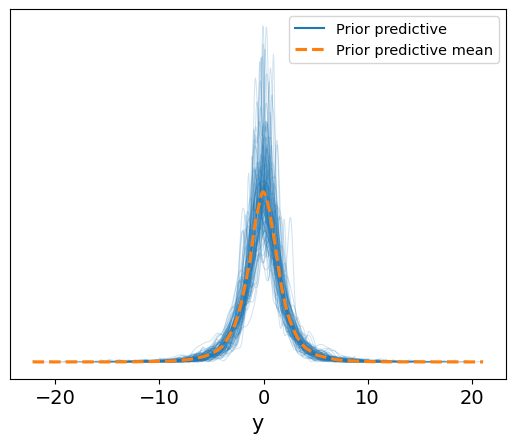

In [5]:
az.plot_ppc(idata, group="prior", kind="kde");

Los datos generados sólo con los priors parecen ser plausibles. Pero podría ver que pasa si los hago menos informativos.

Sampling: [y, μ, σ]


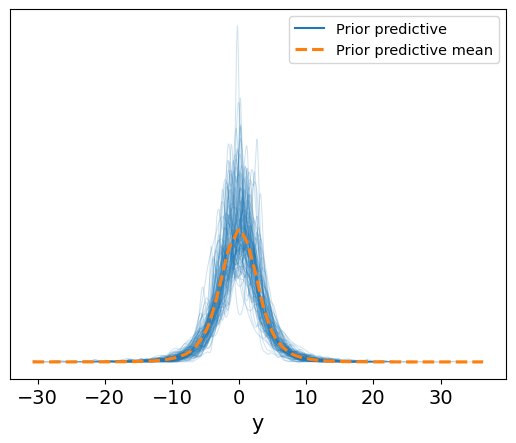

In [6]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=2, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=3, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)
az.plot_ppc(idata, group="prior", kind="kde");

A pesar de no saber nada sobre desplazamientos quimicos supongo, al ver la data, que una differencia de 10 deberia ser casi imposible y, por lo tanto, debería volver a usar los priors de antes.  
Si tuviera conocimiento en el area no debería ver los datos para saber si una diferencia es absurda o imposible, descartaría los priors al ver que algun valor de referencia queda en un lugar que no debería.  (NO ME GUSTA NADA)

## b. 
``cs_nh`` una prueba predictiva a posteriori, todos los grupos juntos

In [7]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


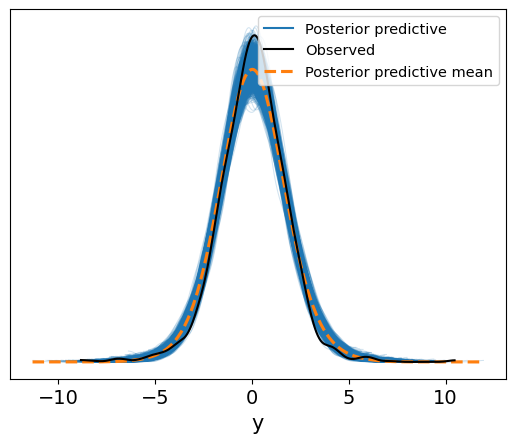

In [8]:
az.plot_ppc(idata);

Se parece bastante pero prodría ser mejor, quizás cambiar los priors para que la _posterior predictive mean_ se acerqué más a la diff observada en el cero. En realidad es innecesario pero ya que estamos vamos a ver que pasa.

In [9]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=0.1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


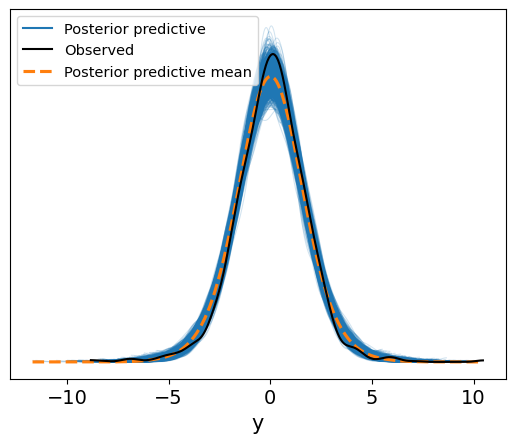

In [10]:
az.plot_ppc(idata);

Los priors son mucho más informativos y la posterior predictive no cambia mucho, supongo que no vale la pena.

## c.
``cs_nh`` una prueba predictiva a posteriori, los 19 grupos por separado

In [11]:
with pm.Model(coords=coords) as cs_nh:
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa")
    σ = pm.HalfNormal('σ', sigma=2, dims="aa")

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()